# Loan Club: Machine Learning Capstone Notebook

In [59]:
# Load packages
import pandas as pd
import numpy as np
import re
from time import strptime  # format data columns
import warnings
import math

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")  # ignore warnings throughout notebook
pd.set_option("display.max_columns", None)  # show all columns

<IPython.core.display.Javascript object>

In [60]:
# Used for auto-formatting code
# terminal - pip install nb_black
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [61]:
# Load Data
filepath = "data/accepted_subsampled_5percent.csv"  # will be personalized
df = pd.read_csv(filepath, sep=",")

df_cleaned = df.copy()  # work from second copy

<IPython.core.display.Javascript object>

In [62]:
# Features known to investors based on LC website
known_vars = ['acc_now_delinq',             # accounts now deliquent
              'collections_12_mths_ex_med', # collections excluding medical
              'fico_range_high',            # credit score range
              'fico_range_low',             # creit score range
              'delinq_2yrs',                # delinquencies in last two years
              'delinq_amnt',                # delinquency amount
              'earliest_cr_line',           # earliest credit line
              'home_ownership',             # home ownership
              'dti',                        # debt2income ratio
              'annual_inc',                 # annual income
              'initial_list_status',        # initial listing status
              'inq_last_6mths',             # credit inquires in last 6mo
              'int_rate',                   # interest rate
              'verification_status_joint',  # is this a joint app
              'emp_length',                 # length of employment (yr)
              'loan_amnt',                  # loan amount
              'id',                         # loan id
              'purpose',                    # purpose of the loan
              'term',                       # loan term (3 or 5yr)
              'addr_state',                 # borrower location state
              'installment',                # montly payment
              'mths_since_last_delinq',     # mo since last delinquency
              'mths_since_last_major_derog',# mo since last maj. derogatory
              'mths_since_last_record',     # mo since last public record
              'open_acc',                   # open credit line
              'pub_rec',                    # public records on file
              'revol_util',                 # revolving balance utilization (%)
              'revol_bal',                  # revolving credit balance ($)
              'tot_coll_amt',               # total collection amount ever
              'total_acc',                  # total credit lines
              'tot_cur_bal',                # total current balance
              'verification_status',        # verified income (Y/N I think)
              'grade'                       # loan grade
             ]

# Sanity check, print variable if not found within original dataframe
# [ print(var) for var in known_vars if (var not in df.columns)]


<IPython.core.display.Javascript object>

### Impute Missing Data of Known Variables

In [63]:
#Assess missingness of known variables
missingness = df_cleaned[known_vars].isnull().mean().T
missingness = missingness.loc[missingness>0].sort_values(ascending=False)
missingness


verification_status_joint      0.949313
mths_since_last_record         0.838543
mths_since_last_major_derog    0.744395
mths_since_last_delinq         0.513786
emp_length                     0.063868
tot_cur_bal                    0.033430
tot_coll_amt                   0.033430
revol_util                     0.001006
dti                            0.000829
collections_12_mths_ex_med     0.000476
open_acc                       0.000185
pub_rec                        0.000185
total_acc                      0.000185
inq_last_6mths                 0.000185
earliest_cr_line               0.000185
delinq_amnt                    0.000185
delinq_2yrs                    0.000185
acc_now_delinq                 0.000185
dtype: float64

<IPython.core.display.Javascript object>

In [64]:
# Drop features missing > 50%
feat_wManyMissing = missingness.index[np.where(missingness > 0.5)].to_list()
df_cleaned[known_vars].drop(df_cleaned[feat_wManyMissing], axis=1, inplace=True)
[
    known_vars.remove(var) for var in feat_wManyMissing
]  # remove features from known_var list
print("Features successfully droppped")

Features successfully droppped


<IPython.core.display.Javascript object>

In [65]:
# Replace NA's of numeric 'known_var' features with mean value
numeric_var = [
    "tot_cur_bal",
    "tot_coll_amt",
    "revol_util",
    "collections_12_mths_ex_med",
    "open_acc",
    "pub_rec",
    "total_acc",
    "inq_last_6mths",
    "delinq_amnt",
    "delinq_2yrs",
    "dti",
]

# List comprehension through numerica variables
[df_cleaned[var].fillna(df[var].mean(), inplace=True) for var in numeric_var]
print("Continuous Variables: Mean imputation completed")

Continuous Variables: Mean imputation completed


<IPython.core.display.Javascript object>

In [66]:
# Helper function to replace missing character strings with randomly selected value
def fillna_random(var):
    #find index of missing values
    miss_idx = df_cleaned.loc[ df_cleaned[var].isnull()].index.tolist()
    
    #find new values to replace NaN values
    new_val = df_cleaned[var].loc[~df_cleaned.index.isin(miss_idx)].sample(len(miss_idx)).values.tolist()

    #replace values
    df_cleaned[var][miss_idx] = new_val

# ==================================================
# Replace NA's of character 'known_var' features with random
non_numeric_var = ['emp_length', 'earliest_cr_line', 'acc_now_delinq', 'delinq_2yrs'] #list of non-numeric variables
[fillna_random(var) for var in non_numeric_var]
print('Categorical Variables: Imputation with random value completed')


Categorical Variables: Imputation with random value completed


<IPython.core.display.Javascript object>

In [67]:
#Sanity check that no more missing values
df_cleaned[known_vars].isnull().sum()


acc_now_delinq                0
collections_12_mths_ex_med    0
fico_range_high               0
fico_range_low                0
delinq_2yrs                   0
delinq_amnt                   0
earliest_cr_line              0
home_ownership                0
dti                           0
annual_inc                    0
initial_list_status           0
inq_last_6mths                0
int_rate                      0
emp_length                    0
loan_amnt                     0
id                            0
purpose                       0
term                          0
addr_state                    0
installment                   0
open_acc                      0
pub_rec                       0
revol_util                    0
revol_bal                     0
tot_coll_amt                  0
total_acc                     0
tot_cur_bal                   0
verification_status           0
grade                         0
dtype: int64

<IPython.core.display.Javascript object>

### Feature Engineering

In [68]:
# Simplify loan status (non-FullyPaid or ChargedOff loans will be converted to NAN)
df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid':'Fully Paid',
                                                           'Charged Off':'Charged Off',
                                                           'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
                                                           'Does not meet the credit policy. Status:Charged Off': 'Charged Off'})

# Remove non-completed loans
df_cleaned.drop(df_cleaned.loc[df_cleaned['loan_status'].isnull()].index.tolist(), axis=0, inplace=True)

# Simplify home ownership
df_cleaned['home_ownership'] = df_cleaned['home_ownership'].map({'MORTGAGE':'mortgage',
                                                                 'OWN':'own',
                                                                 'RENT':'rent'})

# Remove 25 observations without houses
df_cleaned.drop(df_cleaned.loc[df_cleaned['home_ownership'].isnull()].index.tolist(), axis=0, inplace=True)


# Reformat date features and calculate features related to prepayment  
df_cleaned['term_year'] = np.where(df_cleaned['term']==' 36 months', 3,5)
df_cleaned['earliest_cr_line'] =  pd.to_datetime(df_cleaned['earliest_cr_line'])
df_cleaned['issue_date'] =  pd.to_datetime(df_cleaned['issue_d'])
df_cleaned['last_pymnt_date'] = pd.to_datetime(df_cleaned['last_pymnt_d'])
df_cleaned['exp_last_pymnt_date'] = pd.to_datetime(df_cleaned['issue_d'].str[0:3]
                                                   +'-'
                                                   + (df_cleaned['issue_d'].str[-4:].astype('int')
                                                   + df_cleaned['term_year']).astype('str'))

# Calculate credit history ( in months )
date_ofloan = df_cleaned['issue_date'].dt.to_period('M').astype(int)
date_credline = df_cleaned['earliest_cr_line'].dt.to_period('M').astype(int)
df_cleaned['credit_hist_mths'] = date_ofloan - date_credline
df_cleaned['credit_hist_mths'] = np.where(df_cleaned['credit_hist_mths'] < 0, 0, df_cleaned['credit_hist_mths'])

# Log-transform skewed continuous features
df_cleaned['delinq_amnt_log'] = df_cleaned['delinq_amnt'].add(1).apply(np.log)
df_cleaned['annual_inc_log'] = df_cleaned['annual_inc'].add(1).apply(np.log)
df_cleaned['dti_log'] = df_cleaned['dti'].add(1).apply(np.log)
df_cleaned['funded_amnt_log'] = df_cleaned['funded_amnt'].add(1).apply(np.log)
df_cleaned['tot_coll_amt_log'] = df_cleaned['tot_coll_amt'].add(1).apply(np.log)
df_cleaned['tot_cur_bal_log'] = df_cleaned['tot_cur_bal'].add(1).apply(np.log)
df_cleaned['total_acc_log'] = df_cleaned['total_acc'].add(1).apply(np.log)
df_cleaned['revol_bal_log'] = df_cleaned['revol_bal'].add(1).apply(np.log)
df_cleaned['installment_log'] = df_cleaned['installment'].add(1).apply(np.log)
df_cleaned['open_acc_log'] = df_cleaned['open_acc'].add(1).apply(np.log)

# Simplify loan purpose - debt consolidation, credit card, and other
df_cleaned['purpose'] = df_cleaned['purpose'].map({'debt_consolidation':'debt_consolidation',
                                                   'credit_card':'credit_card'})
df_cleaned['purpose'].fillna('other',inplace=True)

# Convert loan grade to ordinal feature
df_cleaned['grade'] = df_cleaned['grade'].map({'A':1,
                                               'B':2,
                                               'C':3,
                                               'D':4,
                                               'E':5,
                                               'F':6,
                                               'G':7})

# Simplify employment length to four categories
df_cleaned['emp_length'] = df_cleaned['emp_length'].map({'< 1 year':0.5,
                                                         '1 year':1,
                                                         '2 years':2,
                                                         '3 years':3,
                                                         '4 years':4,
                                                         '5 years':5,
                                                         '6 years':6,
                                                         '7 years':7,
                                                         '8 years':8,
                                                         '9 years':9,
                                                         '10+ years':10})

# Create new binary features
df_cleaned['has_pub_rec'] = np.where(df_cleaned['pub_rec']>0,1,0) #0-=no public record
df_cleaned['has_paid_early'] = np.where((df_cleaned.loan_status=='Fully Paid')&(df_cleaned.last_pymnt_date < df_cleaned.exp_last_pymnt_date), 1, 0)
df_cleaned['has_36mo_loan'] = np.where(df_cleaned['term'].str.contains('36'),1,0) #0=60mo loan
df_cleaned['has_delinq_now'] = np.where(df_cleaned['acc_now_delinq']>0, 1, 0)
df_cleaned['has_delinq_past2yrs'] = np.where(df_cleaned['delinq_2yrs']>0, 1, 0) #0=no delinq within 2yrs
df_cleaned['has_whole_liststatus'] = np.where(df_cleaned['initial_list_status']=='w', 1, 0) #0=f
df_cleaned['has_fullypaid'] = np.where(df_cleaned['loan_status']=='Fully Paid', 1, 0) #0=charged off


<IPython.core.display.Javascript object>

In [85]:
# Create response variable based on
threshold = -20  # goal % return
df_cleaned["roi_perc"] = (
    df_cleaned["total_pymnt"].div(df_cleaned["funded_amnt"]).sub(1).mul(100)
)
df_cleaned["roi_response"] = np.where(df_cleaned["roi_perc"] > threshold, 1, 0)
df_cleaned["roi_response_charged_off"] = np.where(
    df_cleaned["loan_status"] == "Charged Off", 0, 1
)

print("Fraction of loans above threadhold: %.3f" % df_cleaned["roi_response"].mean())

# ==================================================================
# Majority class [1] = ROI >-20% (IDEAL)
# Minority class [0] = ROI <-20% (BAD)

Fraction of loans above threadhold: 0.838


<IPython.core.display.Javascript object>

In [86]:
# Isolate list of predictor variables to be used for ML
predictor_vars = ['annual_inc_log',
                  'credit_hist_mths',
                  'delinq_amnt_log',
                  'dti_log',
                  'emp_length',
                  'fico_range_high',
                  'funded_amnt_log',
                  'grade',
                  'has_36mo_loan',
                  'has_delinq_now',
                  'has_delinq_past2yrs',
                  'has_pub_rec',
                  'has_whole_liststatus',
                  'home_ownership',
                  'inq_last_6mths',
                  'installment_log',
                  'int_rate',
                  'open_acc_log',
                  'purpose',
                  'revol_bal_log',
                  'revol_util',
                  'tot_coll_amt_log',
                  'tot_cur_bal_log',
                  'total_acc_log',
                  'verification_status']

response_var = 'roi_response'


<IPython.core.display.Javascript object>

# Machine Learning

### Data Preparation

In [87]:
# Dummify categorical features
home_ownership_dummy = pd.get_dummies(df_cleaned['home_ownership'],
                                      prefix="home_ownership").drop('home_ownership_mortgage',axis=1)

purpose_dummy = pd.get_dummies(df_cleaned['purpose'],
                               prefix="purpose").drop('purpose_debt_consolidation',axis=1)

verification_status_dummy = pd.get_dummies(df_cleaned['verification_status'],
                               prefix="verification_status").drop('verification_status_Source Verified',axis=1)


<IPython.core.display.Javascript object>

In [94]:
# List of numeric features in the final dataframe
numeric_vars = [
    "annual_inc_log",
    "credit_hist_mths",
    "delinq_amnt_log",
    "dti_log",
    "emp_length",
    "fico_range_high",
    "funded_amnt_log",
    "grade",
    "has_36mo_loan",
    "has_delinq_now",
    "has_delinq_past2yrs",
    "has_pub_rec",
    "has_whole_liststatus",
    "inq_last_6mths",
    "installment_log",
    "int_rate",
    "open_acc_log",
    "revol_bal_log",
    "revol_util",
    "tot_coll_amt_log",
    "tot_cur_bal_log",
    "total_acc_log",
]

response_var_charged_off = "roi_response_charged_off"

<IPython.core.display.Javascript object>

In [91]:
# final dataframe for model consumption
df_feature_final = pd.concat(
    [
        df_cleaned[numeric_vars],
        home_ownership_dummy,
        purpose_dummy,
        verification_status_dummy,
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### Logistic Regression
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

#### Standardize data

In [98]:
# standardize final dataframe
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_feature_final)
df_feature_final_scaled = pd.DataFrame(scaler.transform(df_feature_final))
df_feature_final_scaled.columns = df_feature_final.columns
df_feature_final_scaled.sample(10)

annual_inc_log  credit_hist_mths  delinq_amnt_log   dti_log  \
1026         0.297428         -0.213882        -0.058612  0.257304   
23055       -0.135760         -0.291164        -0.058612  0.948313   
4146         0.091770         -0.026196        -0.058612  0.298249   
29768        0.363800         -0.500931        -0.058612 -0.272029   
51158       -0.351177         -1.030869        -0.058612  0.523658   
37732        0.751290          0.801832        -0.058612  0.490026   
9478        -0.135760         -1.130232        -0.058612  0.319711   
49936        0.251728          2.347483        -0.058612  0.846570   
19638        1.138781         -0.787981        -0.058612 -0.315836   
67312        0.568330          1.243447        -0.058612 -0.028453   

       emp_length  fico_range_high  funded_amnt_log     grade  has_36mo_loan  \
1026    -0.285603         0.271983         0.455636  0.968740      -1.791407   
23055    1.093390         0.428571        -0.212143  0.198164       0.558221   
4146     1.093390        -0.197780        -1.196901 -0.572411       0.558221   
29768    1.093390        -0.667544         0.772686  0.198164      -1.791407   
51158   -1.112999         0.115395         0.305939  0.198164      -1.791407   
37732    1.093390         0.585159         1.348791 -1.342987       0.558221   
9478    -1.526697        -1.137308        -0.529175  0.968740       0.558221   
49936    1.093390        -0.197780         1.089738  0.198164      -1.791407   
19638    0.817591        -0.197780        -0.212143  0.198164       0.558221   
67312    1.093390         1.681275         1.692127 -0.572411       0.558221   

       has_delinq_now  has_delinq_past2yrs  has_pub_rec  has_whole_liststatus  \
1026        -0.068969            -0.490903    -0.454488             -1.177565   
23055       -0.068969            -0.490903    -0.454488             -1.177565   
4146        -0.068969            -0.490903    -0.454488             -1.177565   
29768       -0.068969            -0.490903     2.200280             -1.177565   
51158       -0.068969             2.037061    -0.454488              0.849210   
37732       -0.068969            -0.490903    -0.454488              0.849210   
9478        -0.068969             2.037061    -0.454488              0.849210   
49936       -0.068969             2.037061     2.200280              0.849210   
19638       -0.068969            -0.490903    -0.454488              0.849210   
67312       -0.068969            -0.490903    -0.454488             -1.177565   

       inq_last_6mths  installment_log  int_rate  open_acc_log  revol_bal_log  \
1026        -0.680439         0.091758  0.421426     -0.577489       0.256872   
23055        2.386638        -0.098748 -0.045777      0.100205      -0.010310   
4146         0.341920        -1.158063 -0.228870      1.418494       0.546144   
29768       -0.680439         0.364539  0.025777      1.055360      -0.015433   
51158        0.341920        -0.054082  0.501398      0.463338      -0.926764   
37732       -0.680439         1.429144 -1.251666     -0.329291       0.784008   
9478        -0.680439        -0.322847  1.061199      0.920712      -0.845611   
49936       -0.680439         0.738253  0.263587      0.100205       1.891160   
19638        0.341920        -0.098748 -0.045777     -0.329291       0.757329   
67312        1.364279         1.887477 -0.348828      0.920712       1.523812   

       revol_util  tot_coll_amt_log  tot_cur_bal_log  total_acc_log  \
1026     1.031305          1.734238         0.496076      -0.896931   
23055   -0.120528         -0.487797        -0.383281       0.657942   
4146     0.787100         -0.487797        -0.461570       0.309287   
29768   -0.303682         -0.487797         0.670237       1.010602   
51158   -1.536916         -0.487797        -0.616211      -0.522782   
37732    1.393542         -0.487797        -0.323310       0.067580   
9478     1.365052         -0.487797         0.003446       0.067580   
499

<IPython.core.display.Javascript object>

In [99]:
# Need to reset index because feature index changed
class_response_neg_20 = df_cleaned[response_var].reset_index().drop("index", axis=1)

class_response_charged_off = (
    df_cleaned[response_var_charged_off].reset_index().drop("index", axis=1)
)

<IPython.core.display.Javascript object>

#### Create Initial Logistic Regression Model

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [101]:
def con_mtx(con_matrix):
    tn, fp, fn, tp = con_matrix.ravel()

    # Calculate metrics
    acc_ = (tp + tn) / (tp + tn + fn + fp)  # accuracy
    err_rate = (fp + fn) / (tp + tn + fn + fp)  # error rate
    sens_ = tp / (tp + fn)  # sensitivity
    sp_ = tn / (tn + fp)  # specificity
    pcs = tp / (tp + fp)  # false positive rate
    rcl = tp / (tp + fn)
    # Print results
    print("Accuracy  : ", acc_)
    print("Error rate  : ", err_rate)
    print("Sensitivity  : ", sens_)
    print("Specificity  : ", sp_)
    print("precision  : ", pcs)
    print("recall  : ", rcl)

<IPython.core.display.Javascript object>

In [102]:
# Quick Glance of the Data
result_neg_20 = sm.Logit(class_response_neg_20, df_feature_final_scaled).fit()

print(result_neg_20.summary())

Optimization terminated successfully.
         Current function value: 0.671440
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           roi_response   No. Observations:                67805
Model:                          Logit   Df Residuals:                    67777
Method:                           MLE   Df Model:                           27
Date:                Mon, 06 Apr 2020   Pseudo R-squ.:                 -0.5175
Time:                        16:51:21   Log-Likelihood:                -45527.
converged:                       True   LL-Null:                       -30002.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
annual_inc_log                       0.0400      0.011      3.65

<IPython.core.display.Javascript object>

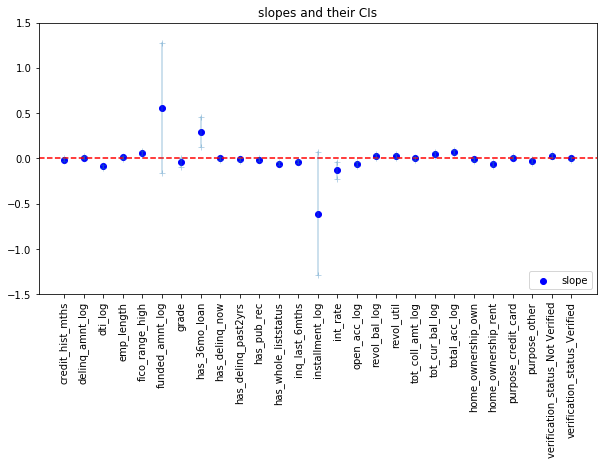

<IPython.core.display.Javascript object>

In [106]:
plt.rcParams["figure.figsize"] = (10, 5)
y_min, y_max = -1.5, 1.5

table_neg_20 = pd.DataFrame(result_neg_20.summary().tables[1].data[1:])
table_neg_20.columns = [
    "name",
    "coef",
    "std err",
    "t value",
    "p value",
    "2.5% confidence",
    "97.5% confidence",
]
table_neg_20 = table_neg_20.astype(
    {
        "name": str,
        "coef": float,
        "std err": float,
        "t value": float,
        "p value": float,
        "2.5% confidence": float,
        "97.5% confidence": float,
    }
)
slope_table_neg_20 = table_neg_20[
    ["name", "coef", "2.5% confidence", "97.5% confidence"]
].iloc[1:]

slope_table_neg_20["y_min"] = slope_table_neg_20["2.5% confidence"].map(
    lambda t: (t - y_min) / (y_max - y_min)
)
slope_table_neg_20["y_max"] = slope_table_neg_20["97.5% confidence"].map(
    lambda t: (t - y_min) / (y_max - y_min)
)
x = range(1, 28)
plt.scatter(x, slope_table_neg_20["coef"], label="slope", c="b")
plt.axhline(0, linestyle="--", c="r")

for i in x:
    plt.axvline(
        i,
        ymin=slope_table_neg_20["y_min"][i],
        ymax=slope_table_neg_20["y_max"][i],
        marker="+",
        alpha=0.3,
    )
plt.xticks(x, slope_table_neg_20.name, rotation="vertical")
plt.ylim((y_min, y_max))
plt.title("slopes and their CIs")
plt.legend(loc=4)

In [107]:
# Train logistic model using class_weight balanced and f1 score (maximizing precision)
lr_neg_20 = LogisticRegression(
    n_jobs=-1,
    solver="liblinear",
    class_weight="balanced",
    # penalty='l2'
)

c_param_neg_20 = {"C": np.logspace(-4, 4, 10), "penalty": ["l1", "l2"]}  # ,
gs_lr_neg_20 = GridSearchCV(lr_neg_20, c_param_neg_20, cv=3, scoring="f1")
gs_lr_neg_20.fit(df_feature_final_scaled, class_response_neg_20)



CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 19.1 µs


<IPython.core.display.Javascript object>

In [108]:
# # CV results
print(gs_lr_neg_20.best_params_)

con_matrix_neg_20 = confusion_matrix(
    class_response_neg_20, gs_lr_neg_20.best_estimator_.predict(df_feature_final_scaled)
)

print("con_mtx:")

print(con_matrix_neg_20)

con_mtx(con_matrix_neg_20)

{'C': 0.005994842503189409, 'penalty': 'l2'}
con_mtx:
[[ 7102  3862]
 [19103 37738]]
Accuracy  :  0.6613081631148146
Error rate  :  0.33869183688518545
Sensitivity  :  0.6639221688569871
Specificity  :  0.6477562933236045
precision  :  0.9071634615384615
recall  :  0.6639221688569871


<IPython.core.display.Javascript object>

#### Feature Selection

In [109]:
sel_neg_20 = SelectFromModel(
    LogisticRegression(
        C=gs_lr_neg_20.best_params_["C"],
        penalty=gs_lr_neg_20.best_params_["penalty"],
        solver="liblinear",
    )
)

sel_neg_20.fit(df_feature_final_scaled, class_response_neg_20)

# 11 Features selected
selected_feat_neg_20 = df_feature_final_scaled.columns[(sel_neg_20.get_support())]
set(np.array(selected_feat_neg_20))

{'dti_log',
 'fico_range_high',
 'funded_amnt_log',
 'grade',
 'has_36mo_loan',
 'has_whole_liststatus',
 'home_ownership_rent',
 'int_rate',
 'open_acc_log',
 'tot_cur_bal_log',
 'total_acc_log'}

<IPython.core.display.Javascript object>

In [110]:
# Features dropped
set(df_feature_final_scaled.columns) - set(selected_feat_neg_20)

{'annual_inc_log',
 'credit_hist_mths',
 'delinq_amnt_log',
 'emp_length',
 'has_delinq_now',
 'has_delinq_past2yrs',
 'has_pub_rec',
 'home_ownership_own',
 'inq_last_6mths',
 'installment_log',
 'purpose_credit_card',
 'purpose_other',
 'revol_bal_log',
 'revol_util',
 'tot_coll_amt_log',
 'verification_status_Not Verified',
 'verification_status_Verified'}

<IPython.core.display.Javascript object>

#### Train-Test Using Only 11 features - generates similar results

In [111]:
from sklearn.model_selection import train_test_split

X_train_neg_20, X_test_neg_20, y_train_neg_20, y_test_neg_20 = train_test_split(
    df_feature_final_scaled[selected_feat_neg_20], class_response_neg_20, test_size=0.2
)

lr_train_neg_20 = LogisticRegression(
    C=gs_lr_neg_20.best_params_["C"],
    penalty=gs_lr_neg_20.best_params_["penalty"],
    n_jobs=-1,
    class_weight="balanced",
    solver="liblinear",
)

lr_train_neg_20.fit(X_train_neg_20, y_train_neg_20)

LogisticRegression(C=0.005994842503189409, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [112]:
# Train Scores
con_mtx(confusion_matrix(y_train_neg_20, lr_train_neg_20.predict(X_train_neg_20)))

Accuracy  :  0.6599070864980459
Error rate  :  0.34009291350195414
Sensitivity  :  0.6647149460708782
Specificity  :  0.6351259360108917
precision  :  0.9037529179385886
recall  :  0.6647149460708782


<IPython.core.display.Javascript object>

In [113]:
# Test Scores
con_mtx(confusion_matrix(y_test_neg_20, lr_train_neg_20.predict(X_test_neg_20)))

Accuracy  :  0.6593171595015117
Error rate  :  0.3406828404984883
Sensitivity  :  0.661028831828937
Specificity  :  0.6502325581395348
precision  :  0.9093429776974081
recall  :  0.661028831828937


<IPython.core.display.Javascript object>

In [114]:
# All Sample Scores
con_mtx(confusion_matrix(class_response_neg_20, 
                         lr_train_neg_20.predict(df_feature_final_scaled[selected_feat_neg_20]))
)


Accuracy  :  0.659789101098739
Error rate  :  0.340210898901261
Sensitivity  :  0.6639749476610194
Specificity  :  0.6380882889456403
precision  :  0.9048646575079718
recall  :  0.6639749476610194


<IPython.core.display.Javascript object>

In [115]:
confusion_matrix(
    class_response_neg_20,
    lr_train_neg_20.predict(df_feature_final_scaled[selected_feat_neg_20]),
)

array([[ 6996,  3968],
       [19100, 37741]])

<IPython.core.display.Javascript object>

### Tree-Based Model
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

- Initially explored Random Forest algorithm but switched to XGboost due to time constraint


In [116]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    precision_score,
    auc,
    recall_score,
    roc_auc_score,
)
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

<IPython.core.display.Javascript object>

#### Naive XGBoost Model - Imbalanced Data (83.8% ROI>-20%)

*Goal is to minimize false positives* - Maximixe precision
- Majority class [1] = ROI >-20% (IDEAL)
- Minority class [0] = ROI <-20% (BAD)


In [117]:
# Create test-train split of data
x = df_feature_final
y = df_cleaned[response_var]  # labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

<IPython.core.display.Javascript object>

In [118]:
# Create random forest object
naive_model = xgb.XGBClassifier(objective="binary:logistic", seed=0)

# Fit model with data
naive_model.fit(x_train, y_train)

# Analyze
model = naive_model
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(x_test)).ravel()
results = {
    "auc_PR": round(average_precision_score(y_test, model.predict(x_test)), 4),
    "accuracy": round((tp + tn) / (tp + tn + fn + fp), 4),
    "recall": round(tp / (tp + fn), 4),
    "precision": round(tp / (tp + fp), 4),
    "false_discovery_rate": round(fp / (fp + tp), 4),
    "false_pos_rate": round(fp / (tn + fp), 4),
    "error_rate": round((fp + fn) / (tp + tn + fn + fp), 4),
    "n_true_pos": tp,
    "n_false_pos": fp,
}
results

# # ==================== Print Results ====================
# model = naive_model
# y_pred = model.predict(x_test)
# auc_PR = average_precision_score(y_test, y_pred)
# precision, recall, _ = precision_recall_curve(y_test, y_pred)
# plt.plot(recall, precision)
# plt.xlabel('Recall (True Positive) ')
# plt.ylabel('Precision (Proportion Correct)')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Binary Precision-Recall curve: '
#                    'auc_PR={0:0.2f}'.format(auc_PR))

{'auc_PR': 0.8406,
 'accuracy': 0.8381,
 'recall': 0.9958,
 'precision': 0.8406,
 'false_discovery_rate': 0.1594,
 'false_pos_rate': 0.9817,
 'error_rate': 0.1619,
 'n_true_pos': 11326,
 'n_false_pos': 2147}

<IPython.core.display.Javascript object>

#### Naive XGBoost Model - using scale_pos_weight parameter

In [119]:
# Create random forest object
# scale_pos_weight = sum(negative) / sum(positive)
naive_spw_model = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=(len(y) - y.sum()) / y.sum(),  # 0.1929
    seed=0,
)

# Fit model with data
naive_spw_model.fit(x_train, y_train)

# Analyze
model = naive_spw_model
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(x_test)).ravel()
naive_spw_results = {
    "weight": round((len(y) - y.sum()) / y.sum(), 4),
    "auc_PR": round(average_precision_score(y_test, model.predict(x_test)), 4),
    "accuracy": round((tp + tn) / (tp + tn + fn + fp), 4),
    "recall": round(tp / (tp + fn), 4),
    "precision": round(tp / (tp + fp), 4),
    "false_discovery_rate": round(fp / (fp + tp), 4),
    "false_pos_rate": round(fp / (tn + fp), 4),
    "error_rate": round((fp + fn) / (tp + tn + fn + fp), 4),
    "n_true_pos": tp,
    "n_false_pos": fp,
}
naive_spw_results

# # ==================== Print Results ====================
# model = naive_model
# y_pred = model.predict(x_test)
# auc_PR = average_precision_score(y_test, y_pred)
# precision, recall, _ = precision_recall_curve(y_test, y_pred)
# plt.plot(recall, precision)
# plt.xlabel('Recall (True Positive) ')
# plt.ylabel('Precision (Proportion Correct)')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Binary Precision-Recall curve: '
#                    'auc_PR={0:0.2f}'.format(auc_PR))

{'weight': 0.1929,
 'auc_PR': 0.8832,
 'accuracy': 0.6404,
 'recall': 0.635,
 'precision': 0.9088,
 'false_discovery_rate': 0.0912,
 'false_pos_rate': 0.3315,
 'error_rate': 0.3596,
 'n_true_pos': 7223,
 'n_false_pos': 725}

<IPython.core.display.Javascript object>

**Tuning Hyperparameters**
- max_depth = depth of trees (3-10)
- min_child_weight = similar to min_child_leaf for RandomForest
- gamma = min. loss reduction required for split
- subsample = frac of observations randomly sampled for tree (0.5-1)
- colsample_bytree = number of features sampled for each tree
- learning rate = typically between 0.01-0.2

In [120]:
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
# from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


<IPython.core.display.Javascript object>

In [121]:
# def grid_search_wrapper(refit_score='precision_score'):
#     """
#     fits a GridSearchCV classifier using refit_score for optimization
#     prints classifier performance metrics
#     """

#     skf = StratifiedKFold(n_splits=5)
#     grid_search = GridSearchCV(model,
#                                      param_grid,
#                                      scoring=scorers,
#                                      refit=refit_score,
#                                      cv=skf,
#                                      verbose=1,
#                                      return_train_score=True,
#                                      n_jobs = -1)

#     grid_search.fit(x_train, y_train)

#     # make the predictions
#     y_pred = grid_search.predict(x_test)

#     print('Best params for {}'.format(refit_score))
#     print(grid_search.best_params_)

#     # confusion matrix on the test data.
#     print('\nConfusion matrix of XGBoost optimized for {} on the test data:'.format(refit_score))
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#     precision = round(tp/(tp+fp),4) * 100
#     print("\nPrecision: {0}% of loans identified as a good loan (ROI>-20%) were correct\n".format(precision))

#     false_discovery_rate = round(fp/(fp+tp),4) * 100
#     print("False discovery rate: {0}% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]\n\n".format(false_discovery_rate))

#     return grid_search

<IPython.core.display.Javascript object>

In [122]:
# %%time
# #Based on link: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

# xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',
#                               early_stopping_rounds = 5,
#                               scale_pos_weight = (len(y)-y.sum())/y.sum())


# c

# scorers = {
#     'precision_score': make_scorer(precision_score),
# }

# grid_search_model = grid_search_wrapper(refit_score='precision_score')



<IPython.core.display.Javascript object>

## Results

### Naive Model

In [123]:
#Confusion Matrix
y_pred = naive_spw_model.predict(x_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

#CM Calculations
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

accuracy = round( 100*(tp + tn) / (tp + tn + fn + fp) ,2)
print("\nAccuracy: {0}% of loans were correctly identified\n".format(accuracy))

specificity = round(tn / (tn + fp),4) * 100 #true negative rate
print("Specificity: {0}% of loans with ROI<-20% were identified as a bad loan loan\n".format(specificity))

recall = round(tp / (tp + fn), 4) * 100 #true positive rate
print("Recall/Sensitivity: {0}% of loans with ROI>-20% were identified as a good loan\n".format(recall))

precision = round(tp/(tp+fp),4) * 100
print("Precision: {0}% of loans identified as a good loan (ROI>-20%) were correct\n".format(precision))

false_discovery_rate = round(fp/(fp+tp),4) * 100
print("False discovery rate: {0}% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]\n".format(false_discovery_rate))

false_pos_rate = round(fp / (tn + fp),4) * 100
print("False Positive Rate: {0}% of bad loans [ROI<-20%] were identified as a good loan [ROI>-20%]\n".format(false_pos_rate))


     pred_neg  pred_pos
neg      1462       725
pos      4151      7223

Accuracy: 64.04% of loans were correctly identified

Specificity: 66.85% of loans with ROI<-20% were identified as a bad loan loan

Recall/Sensitivity: 63.5% of loans with ROI>-20% were identified as a good loan

Precision: 90.88000000000001% of loans identified as a good loan (ROI>-20%) were correct

False discovery rate: 9.120000000000001% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]

False Positive Rate: 33.15% of bad loans [ROI<-20%] were identified as a good loan [ROI>-20%]



<IPython.core.display.Javascript object>

### Balanced Model

In [124]:
xgb_balanced = xgb.XGBClassifier(objective = 'binary:logistic',
                              early_stopping_rounds = 5,
                              scale_pos_weight = (len(y)-y.sum())/y.sum(),
                              seed = 0,
                              colsample_bytree = 0.9, 
                              max_depth = 1, 
                              n_estimators = 500,
                              subsample = 0.5,
                              n_jobs = -1)

xgb_balanced.fit(x_train, y_train)

#Confusion Matrix
y_pred = xgb_balanced.predict(x_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

# #CM Calculations
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(x_test)).ravel()

accuracy = round( 100*(tp + tn) / (tp + tn + fn + fp) ,2)
print("\nAccuracy: {0}% of loans were correctly identified\n".format(accuracy))

specificity = round(tn / (tn + fp),4) * 100 #true negative rate
print("Specificity: {0}% of loans with ROI<-20% were identified as a bad loan loan\n".format(specificity))

recall = round(tp / (tp + fn), 4) * 100 #true positive rate
print("Recall/Sensitivity: {0}% of loans with ROI>-20% were identified as a good loan\n".format(recall))

precision = round(tp/(tp+fp),4) * 100
print("Precision: {0}% of loans identified as a good loan (ROI>-20%) were correct\n".format(precision))

false_discovery_rate = round(fp/(fp+tp),4) * 100
print("False discovery rate: {0}% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]\n".format(false_discovery_rate))

false_pos_rate = round(fp / (tn + fp),4) * 100
print("False Positive Rate: {0}% of bad loans [ROI<-20%] were identified as a good loan [ROI>-20%]\n".format(false_pos_rate))



     pred_neg  pred_pos
neg      1477       710
pos      4225      7149

Accuracy: 64.04% of loans were correctly identified

Specificity: 66.85% of loans with ROI<-20% were identified as a bad loan loan

Recall/Sensitivity: 63.5% of loans with ROI>-20% were identified as a good loan

Precision: 90.88000000000001% of loans identified as a good loan (ROI>-20%) were correct

False discovery rate: 9.120000000000001% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]

False Positive Rate: 33.15% of bad loans [ROI<-20%] were identified as a good loan [ROI>-20%]



<IPython.core.display.Javascript object>

#### Feature Importance

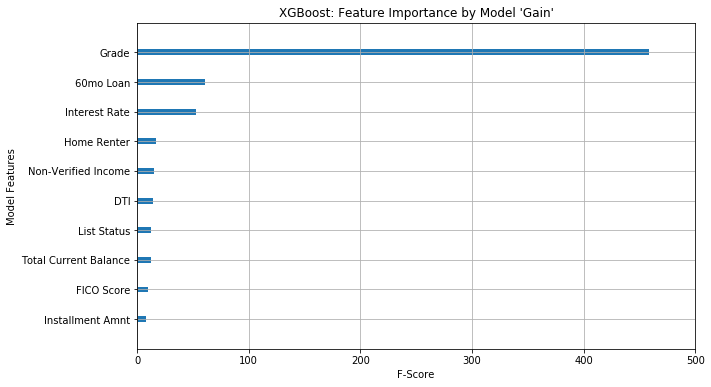

<IPython.core.display.Javascript object>

In [125]:
plt.rcParams["figure.figsize"] = (10, 6)
ax = xgb.plot_importance(
    xgb_balanced,
    ax=None,
    title="XGBoost: Feature Importance by Model 'Gain'",
    xlabel="F-Score",
    ylabel="Model Features",
    importance_type="gain",
    max_num_features=10,
    grid=True,
    show_values=False,
    xlim=(0, 500),
)

tick_labels = [
    "Installment Amnt",
    "FICO Score",
    "Total Current Balance",
    "List Status",
    "DTI",
    "Non-Verified Income",
    "Home Renter",
    "Interest Rate",
    "60mo Loan",
    "Grade",
]
ax.set_yticklabels(tick_labels)

plt.savefig("xgboost_feature_importance.pdf", bbox_inches="tight")


In [127]:
# Export Results

xgboost_output = pd.concat([x_test, y_test], axis=1)
xgboost_output["y_predict"] = y_pred

xgboost_output = pd.merge(
    xgboost_output,
    df_cleaned["roi_perc"],
    left_on=xgboost_output.index,
    right_on=df_cleaned["roi_perc"].index,
)

xgboost_output.to_csv(path_or_buf="data/xgboost_output.csv", sep=",")

<IPython.core.display.Javascript object>